In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
#os.environ["NUMBA_ENABLE_CUDASIM"] = "1" 
from numba import jit, vectorize, cuda, njit, float32, int16

Note that the variable __os.environ["NUMBA_ENABLE_CUDASIM"] = "1"__ is commented because I used my GPU for CUDA kernels. Either in this notebook (09ex) and in the 09, complicate CUDA kernels (2D kernels) are executed extremely slowly using the CUDA Simulator. I do not know which is the issue but this can come from the fact that I am not using Anaconda but pip Python. Anyway I managed to run the code using CUDA on my GPU.

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [2]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_log(x):
    c = np.log(x)
    return c

a = np.array([2,5,10,3,8]).astype(np.float32)

print('log(A) = ', vec_log(a))

@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_exp(x):
    c = np.exp(x)
    return c

a = np.array([2,5,10,3,8]).astype(np.float32)

print('exp(A) = ', vec_exp(a))

log(A) =  [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
exp(A) =  [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

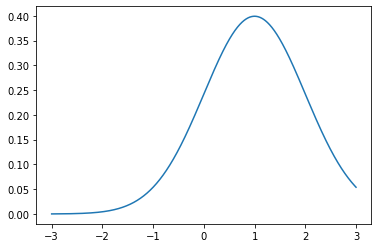

In [3]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def vec_gauss(x):
    c = 1/np.sqrt(2*np.pi) * np.exp(-(x-1)**2/2)
    return c

x = np.linspace(-3, 3, 100000).astype(np.float32)
y = vec_gauss(x)
plt.plot(x, y)
plt.show()

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$threshold = 15$

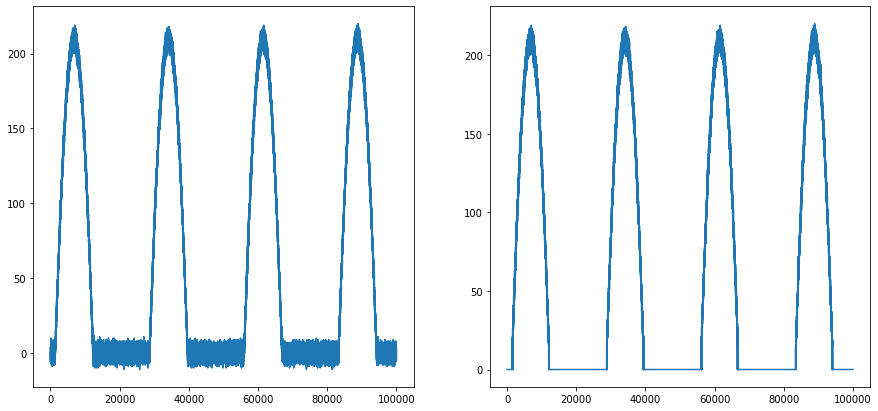

In [4]:
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,7))
ax1.plot(range(n), data)
mag = np.int16(15)

@vectorize([int16(int16, int16)], target='parallel', fastmath=True)
def zero_suppression(x, mag):
    if np.abs(x) < mag:
        c = 0
    else:
        c = x
    return c

data_supp = zero_suppression(data, mag)
ax2.plot(range(n), data_supp)
plt.show()

In [5]:
@cuda.jit
def increment_kernel(io_array):
    pos = cuda.grid(1)
    # x, y = cuda.grid(2) # For 2D array
    if pos < io_array.size:
        io_array[pos] += 1 # do the computation

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [6]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)
K = np.zeros((3,3))
a = 1
c = 0

@cuda.jit
def sigmoid(x, y, k, a, c):
    row, col = cuda.grid(2)
    if row < k.shape[0] and col < k.shape[1]:
        e = 0
        for i in range(x.shape[1]):
            e += x[i][row]*y[i][col]
        k[row][col] = math.tanh(e)

threadsperblock = (32, 32)
blockspergrid_x = int(math.ceil(K.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(K.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

sigmoid[threadsperblock, blockspergrid](X, Y, K, a, c)
print(K)

[[0.39655156 0.58982627 0.36609405]
 [0.20221281 0.34156081 0.16886191]
 [0.17417661 0.28353646 0.12631915]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [7]:
@cuda.jit()
def kernel_cos(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x][y][z] = math.cos(io_array[x][y][z]) # do the computation

# Host code   
data = np.pi*np.ones((256, 256, 256))

# Configure the blocks
threadsperblock = (16,8,8) 
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
kernel_cos[blockspergrid, threadsperblock](data)
print(data)
print('shape :', data.shape)

[[[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 ...

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x22$

A and B must be randomly generated and only int values are allowed.


In [8]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B"""
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(10, size=(24,12))
B = np.random.randint(10, size=(12, 22))
C = np.zeros((24,22))

# Configure the blocks
threadsperblock = (32, 32)
blockspergrid_x = int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(C.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A, B, C)
print(C)
print('shape :', C.shape)

[[218. 150. 215. 264. 241. 212. 167. 147. 172. 178. 181. 208. 174. 249.
  274. 222. 207. 228. 173. 211. 225. 263.]
 [239. 293. 386. 419. 374. 345. 335. 233. 227. 284. 319. 330. 357. 308.
  344. 321. 296. 331. 278. 343. 295. 429.]
 [173. 147. 258. 314. 323. 260. 229. 153. 212. 284. 168. 265. 252. 266.
  302. 239. 259. 306. 224. 274. 253. 343.]
 [288. 253. 359. 395. 409. 356. 275. 185. 224. 292. 248. 339. 305. 366.
  378. 311. 265. 350. 282. 328. 334. 419.]
 [259. 253. 327. 410. 381. 290. 300. 190. 252. 269. 318. 318. 318. 334.
  359. 327. 294. 315. 234. 305. 333. 390.]
 [215. 147. 223. 275. 260. 205. 162. 112. 150. 203. 150. 204. 182. 239.
  282. 227. 214. 217. 171. 208. 227. 244.]
 [265. 229. 291. 353. 290. 246. 243. 182. 205. 200. 251. 256. 249. 269.
  325. 308. 265. 271. 192. 250. 273. 295.]
 [374. 252. 459. 531. 421. 435. 301. 259. 273. 291. 356. 409. 351. 394.
  438. 385. 395. 397. 340. 432. 372. 440.]
 [283. 156. 335. 379. 246. 282. 213. 197. 178. 215. 245. 261. 239. 268.
  316. 2